In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import norm
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
# Constants
N_SAMPLES = 12000
TEST_SIZE = 0.1
RANDOM_STATE = 42
LATENT_DIM = 10
BINS = 50
LAMBDA_CLASSIFICATION = 555.0
LAMBDA_MI = 10.0
LAMBDA_MSE = 830.0
LAMBDA_KL = 10.0
LAMBDA_FIXED = 0.5
EPOCHS = 300
BATCH_SIZE = 64
LEARNING_RATE = 5e-4
FIXED_SIZE = 0


In [57]:
def generate_data(n_samples=N_SAMPLES):
    """Generate synthetic data with structural equations."""
    np.random.seed(42)
    X1 = np.random.normal(1, 0.6, n_samples)
    X2 = X1**2 + np.random.normal(0, 0.25, n_samples)
    X3 = 1.5 + np.sin(-4 * X1) + np.random.normal(0, 0.5, n_samples)
    X4 = np.clip(np.random.normal(2, 1, n_samples), None, 3.36)
    X5 = 1 / np.exp(-1.5 * X4) + 2 + np.random.normal(0, 2, n_samples)
    X_orig = np.column_stack([X1, X2, X3, X4, X5])
    y_orig = np.all(np.sin(X_orig[:, :5]) > 0, axis=1).astype(int)
    return X_orig, y_orig



In [58]:
def split_and_oversample_data(X_orig, y_orig, n_samples=N_SAMPLES, test_size=TEST_SIZE):
    """Split data and oversample class 1."""
    X_train = X_orig[:int((1-test_size)*n_samples)]
    X_test = X_orig[int((1-test_size)*n_samples):]
    y_train = y_orig[:int((1-test_size)*n_samples)]
    y_test = y_orig[int((1-test_size)*n_samples):]
    idx_1 = np.where(y_train == 1)[0]
    X_added = X_train[idx_1].copy()
    X_added[:, :5] += np.random.normal(1, 0.5, (idx_1.shape[0], 5))
    y_added = y_train[idx_1].astype(int)
    X_train = np.concatenate((X_train, X_added), axis=0).astype(np.float32)
    y_train = np.concatenate((y_train, y_added), axis=0).astype(np.int32)
    return X_train, X_test, y_train, y_test



In [59]:
def estimate_mi(x, y, bins=BINS):
    """Estimate mutual information between two features using histograms."""
    hist_2d, x_edges, y_edges = np.histogram2d(x, y, bins=bins, density=True)
    p_xy = hist_2d / (np.sum(hist_2d) + 1e-10)
    p_x = np.sum(p_xy, axis=1) + 1e-10
    p_y = np.sum(p_xy, axis=0) + 1e-10
    p_x_p_y = np.outer(p_x, p_y)
    valid = (p_xy > 1e-10) & (p_x_p_y > 1e-10)
    mi = np.sum(p_xy[valid] * np.log(p_xy[valid] / p_x_p_y[valid]))
    return mi if np.isfinite(mi) else 0.0



In [60]:
def compute_mi_and_ranges(X_train, bins=BINS):
    """Precompute mutual information and feature ranges."""
    n_features = X_train.shape[1]
    mi_original = {}
    feature_ranges = {}
    for i, j in combinations(range(n_features), 2):
        mi = estimate_mi(X_train[:, i], X_train[:, j], bins=bins)
        mi_original[(i, j)] = mi
        feature_ranges[(i, j)] = (
            min(X_train[:, i].min(), X_train[:, j].min()),
            max(X_train[:, i].max(), X_train[:, j].max())
        )
    return mi_original, feature_ranges



In [61]:
def compute_feature_weights(X_train):
    """Compute feature weights based on standard deviation."""
    feature_std = np.std(X_train, axis=0)
    return 1.0 / (feature_std + 1e-10)



In [62]:
def compute_mean_normalized_l2_distance(factuals, counterfactuals, feature_types, data):
    """Compute mean L2-normalized distance, normalizing by feature ranges."""
    assert factuals.shape == counterfactuals.shape, "Shape mismatch between factuals and counterfactuals"
    assert factuals.shape[1] == len(feature_types), "Feature types length mismatch"
    assert data.shape[1] == factuals.shape[1], "Data and factuals must have same number of features"

    n_samples, n_features = factuals.shape
    feature_ranges = []
    for j in range(n_features):
        if feature_types[j] == 'continuous':
            max_val = np.max(data[:, j])
            min_val = np.min(data[:, j])
            range_val = max_val - min_val
            feature_ranges.append(range_val if range_val != 0 else 1e-8)
        else:
            feature_ranges.append(1.0)
    distances = []
    for i in range(n_samples):
        dist_sq = 0
        for j in range(n_features):
            f, cf = factuals[i, j], counterfactuals[i, j]
            if feature_types[j] == 'continuous':
                norm_diff = (f - cf) / feature_ranges[j]
                dist_sq += norm_diff ** 2
            elif feature_types[j] == 'categorical':
                dist_sq += 0 if f == cf else 1
            else:
                raise ValueError(f"Unknown feature type: {feature_types[j]}")
        distances.append(np.sqrt(dist_sq))
    return np.mean(distances)



In [63]:
class MILossLayer(keras.layers.Layer):
    """Custom layer for mutual information loss, computed per sample."""
    def __init__(self, bins, feature_ranges, mi_original_tf, lambda_mi, **kwargs):
        super(MILossLayer, self).__init__(**kwargs)
        self.bins = bins
        self.feature_ranges = feature_ranges
        self.mi_original_tf = mi_original_tf
        self.lambda_mi = lambda_mi

    def call(self, inputs):
        x_recon = inputs
        batch_size = tf.shape(x_recon)[0]
        mi_losses = tf.zeros((batch_size,), dtype=tf.float32)

        for i, j in combinations(range(x_recon.shape[1]), 2):
            x_i = x_recon[:, i]
            x_j = x_recon[:, j]
            vmin, vmax = self.feature_ranges[(i, j)]
            vmin = tf.constant(vmin, dtype=tf.float32)
            vmax = tf.constant(vmax, dtype=tf.float32)
            bin_edges = tf.linspace(vmin, vmax, self.bins + 1)
            x_i_bin = tf.searchsorted(bin_edges, x_i, side='right') - 1
            x_j_bin = tf.searchsorted(bin_edges, x_j, side='right') - 1
            x_i_bin = tf.clip_by_value(x_i_bin, 0, self.bins - 1)
            x_j_bin = tf.clip_by_value(x_j_bin, 0, self.bins - 1)
            flat_indices = x_i_bin * self.bins + x_j_bin
            hist_1d = tf.math.bincount(flat_indices, minlength=self.bins * self.bins)
            hist_2d = tf.cast(tf.reshape(hist_1d, (self.bins, self.bins)), tf.float32)
            p_xy = hist_2d / (tf.reduce_sum(hist_2d) + 1e-10)
            p_x = tf.reduce_sum(p_xy, axis=1) + 1e-10
            p_y = tf.reduce_sum(p_xy, axis=0) + 1e-10
            p_x_p_y = tf.expand_dims(p_x, 1) * tf.expand_dims(p_y, 0)
            valid = (p_xy > 1e-10) & (p_x_p_y > 1e-10)
            mi = tf.reduce_sum(tf.where(valid, p_xy * tf.math.log(p_xy / (p_x_p_y + 1e-10)), 0.0))
            mi_loss = tf.abs(mi - self.mi_original_tf[(i, j)])
            mi_losses += mi_loss

        mi_losses = mi_losses / len(self.mi_original_tf)
        self.add_loss(self.lambda_mi * tf.reduce_mean(mi_losses))
        return x_recon

    def get_config(self):
        config = super(MILossLayer, self).get_config()
        config.update({
            "bins": self.bins,
            "feature_ranges": self.feature_ranges,
            "mi_original_tf": {k: v.numpy() for k, v in self.mi_original_tf.items()},
            "lambda_mi": self.lambda_mi
        })
        return config



In [64]:
def build_encoder(latent_dim=LATENT_DIM):
    """Build the encoder model."""
    encoder_inputs = keras.Input(shape=(5,), name='X')
    x = layers.Dense(128, activation='relu')(encoder_inputs)
    x = layers.Dense(32, activation='relu')(x)
    mu = layers.Dense(latent_dim, name='mu')(x)
    log_var = layers.Dense(latent_dim, name='log_var')(x)
    return keras.Model(encoder_inputs, [mu, log_var], name='encoder')

def build_decoder(latent_dim=LATENT_DIM):
    """Build the decoder model with actionability."""
    z_inputs = keras.Input(shape=(latent_dim,), name='z')
    t_inputs = keras.Input(shape=(1,), name='t')
    mask_inputs = keras.Input(shape=(5,), name='mask')
    vae_inputs = keras.Input(shape=(5,), name='X_input')
    decoder_inputs = layers.Concatenate(name='decoder_input')([z_inputs, t_inputs])
    x = layers.Dense(32, activation='relu')(decoder_inputs)
    x = layers.Dense(128, activation='relu')(x)
    x_recon = layers.Dense(5, name='X_recon')(x)
    CF = mask_inputs * vae_inputs + (1 - mask_inputs) * x_recon
    return keras.Model([z_inputs, t_inputs, mask_inputs, vae_inputs], [x_recon, CF], name='decoder')

def build_vae(encoder, decoder, clf, mi_original_tf, feature_ranges, feature_weights,
              lambda_classification=LAMBDA_CLASSIFICATION, lambda_mi=LAMBDA_MI,
              lambda_mse=LAMBDA_MSE, lambda_kl=LAMBDA_KL, lambda_fixed=LAMBDA_FIXED, bins=BINS):
    """Build and compile the VAE model with actionability."""
    vae_inputs = keras.Input(shape=(5,), name='X_input')
    t_inputs = keras.Input(shape=(1,), name='t_input')
    mask_inputs = keras.Input(shape=(5,), name='mask_input')
    mu, log_var = encoder(vae_inputs)
    epsilon = tf.random.normal(shape=(tf.shape(mu)[0], LATENT_DIM))
    z = mu + tf.exp(0.5 * log_var) * epsilon
    x_recon, CF = decoder([z, t_inputs, mask_inputs, vae_inputs])
    x_recon = MILossLayer(bins=bins, feature_ranges=feature_ranges, 
                          mi_original_tf=mi_original_tf, lambda_mi=lambda_mi)(CF)
    vae = keras.Model([vae_inputs, t_inputs, mask_inputs], [x_recon, CF], name='vae')

    # KL Divergence Loss
    kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
    vae.add_loss(lambda_kl * tf.reduce_mean(kl_loss))

    # Classification Loss (on CF)
    clf.trainable = False
    p = clf(CF)
    classification_loss = tf.keras.losses.sparse_categorical_crossentropy(t_inputs, p)
    vae.add_loss(lambda_classification * tf.reduce_mean(classification_loss))

    # Weighted MSE Loss (on x_recon)
    mse_loss = tf.reduce_mean(feature_weights * tf.square(vae_inputs - x_recon), axis=-1)
    vae.add_loss(lambda_mse * tf.reduce_mean(mse_loss))

    # Fixed Feature Reconstruction Loss
    fixed_recon_loss = tf.reduce_mean(mask_inputs * tf.square(vae_inputs - x_recon), axis=-1)
    vae.add_loss(lambda_fixed * tf.reduce_mean(fixed_recon_loss))

    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return vae



In [65]:
class PreservationCallback(keras.callbacks.Callback):
    """Callback to monitor fixed feature preservation."""
    def __init__(self, X_val, t_val, mask_val):
        super().__init__()
        self.X_val = X_val
        self.t_val = t_val
        self.mask_val = mask_val
        self.tolerance = 1e-5

    def on_epoch_end(self, epoch, logs=None):
        if np.any(self.mask_val):
            x_recon_val, CF_val = self.model.predict([self.X_val, self.t_val, self.mask_val], verbose=0)
            diff_cf = np.abs(self.X_val - CF_val) * self.mask_val
            preserved_cf = np.all(diff_cf <= self.tolerance, axis=1)
            preservation_rate_cf = np.mean(preserved_cf)
            diff_recon = np.abs(self.X_val - x_recon_val) * self.mask_val
            preserved_recon = np.all(diff_recon <= self.tolerance, axis=1)
            preservation_rate_recon = np.mean(preserved_recon)
        else:
            preservation_rate_cf = 1.0
            preservation_rate_recon = 1.0
        print(f"Epoch {epoch + 1}: CF Preservation Rate = {preservation_rate_cf:.4f}, x_recon Preservation Rate = {preservation_rate_recon:.4f}")



In [66]:
def generate_counterfactuals(vae, clf, X_test, y_test, fixed_size=FIXED_SIZE):
    """Generate and verify counterfactuals with actionability."""
    t_test = (1 - np.argmax(clf.predict(X_test, verbose=0), axis=1)).reshape(-1, 1).astype(np.float32)
    mask_test = np.zeros((X_test.shape[0], 5), dtype=np.float32)
    if fixed_size > 0:
        cols = np.array([np.random.choice(5, size=fixed_size, replace=False) for _ in range(X_test.shape[0])])
        rows = np.repeat(np.arange(X_test.shape[0]), fixed_size)
        mask_test[rows, cols.flatten()] = 1.0
    outputs = vae.predict([X_test, t_test, mask_test], verbose=0)
    x_recon, X_test_recon = outputs[0], outputs[1]
    original_probs = clf.predict(X_test, verbose=0)
    original_classes = np.argmax(original_probs, axis=1)
    counterfactual_probs = clf.predict(X_test_recon, verbose=0)
    counterfactual_classes = np.argmax(counterfactual_probs, axis=1)
    flip_success = np.mean(original_classes != counterfactual_classes)
    print(f"Flip percentage: {flip_success * 100:.2f}%")
    if flip_success < 0.5:
        print("Warning: Low flip percentage. Consider relaxing fixed feature constraints.")
    return X_test_recon, t_test, mask_test, original_classes, counterfactual_classes



In [71]:
def compute_metrics(X_test, X_test_recon, original_classes, counterfactual_classes, 
                   X_train, y_train, autoencoder_0, autoencoder_1, X_train_full):
    """Compute validity, distance, CES, DPS, and IM1 metrics."""
    # Validity (flip percentage)
    validity = np.mean(original_classes != counterfactual_classes)

    # Distance (mean L2-normalized)
    feature_types = ['continuous'] * 5  # All features are continuous
    distance = compute_mean_normalized_l2_distance(X_test, X_test_recon, feature_types, X_train_full)

    # CES (Causal Edge Score)
    def compute_log_likelihood(value, mean, std):
        return norm.logpdf(value, loc=mean, scale=std)

    def compute_all_log_likelihoods(X):
        X1, X2, X3, X4, X5 = X[:, 0], X[:, 1], X[:, 2], X[:, 3], X[:, 4]
        ll = np.zeros_like(X1)
        ll += compute_log_likelihood(X1, 1, 0.6)
        ll += compute_log_likelihood(X2, X1**2, 0.25)
        ll += compute_log_likelihood(X3, 1.5 + np.sin(-4 * X1), 0.5)
        ll += compute_log_likelihood(X4, 2, 1)
        return ll

    ll_cf = compute_all_log_likelihoods(X_test_recon)
    ll_x = compute_all_log_likelihoods(X_test)
    ces = np.mean(ll_cf - ll_x)

    # DPS (Structural)
    train_df = pd.DataFrame(X_train, columns=[f"X{i+1}" for i in range(5)])
    cf_df = pd.DataFrame(X_test_recon, columns=[f"X{i+1}" for i in range(5)])
    dependencies = {'X2': ['X1'], 'X3': ['X1'], 'X5': ['X4']}
    models = {}
    for target, parents in dependencies.items():
        X = train_df[parents]
        y = train_df[target]
        model = GradientBoostingRegressor() if target in ['X3', 'X5'] else LinearRegression()
        model.fit(X, y)
        models[target] = model
    errors = []
    for target, parents in dependencies.items():
        X_cf = cf_df[parents]
        y_cf_true = cf_df[target]
        y_cf_pred = models[target].predict(X_cf)
        std = train_df[target].std()
        normalized_error = np.abs(y_cf_pred - y_cf_true) / std
        scores = np.exp(-normalized_error)
        errors.append(scores)
    dps = np.mean(np.stack(errors, axis=1), axis=1).mean()

    # IM1 (Reconstruction Ratio)
    reconstruction_ratios = []
    for i in range(len(X_test_recon)):
        x_cf = X_test_recon[i].reshape(1, -1)
        y_orig = original_classes[i]
        y_cf = counterfactual_classes[i]
        if y_orig == 0 and y_cf == 1:
            AE_o = autoencoder_0
            AE_t = autoencoder_1
        elif y_orig == 1 and y_cf == 0:
            AE_o = autoencoder_1
            AE_t = autoencoder_0
        else:
            continue
        loss_t = np.mean(np.square(x_cf - AE_t.predict(x_cf, verbose=0)))
        loss_o = np.mean(np.square(x_cf - AE_o.predict(x_cf, verbose=0)))
        if loss_o > 0:
            ratio = loss_t / loss_o
            reconstruction_ratios.append(ratio)
    im1 = np.mean(reconstruction_ratios) if reconstruction_ratios else 0.0

    return {
        'Validity': validity,
        'Distance': distance,
        'CES': ces,
        'DPS': dps,
        'IM1': im1
    }



In [72]:
def plot_scatter(X_orig, X_test_recon, y_orig, counterfactual_classes):
    """Generate scatter plots for X1 vs X2, X1 vs X3, and X4 vs X5."""
    idx_0 = np.where(y_orig == 0)[0]
    idx_1 = np.where(y_orig == 1)[0]
    idxcf_0 = np.where(counterfactual_classes == 0)[0]
    idxcf_1 = np.where(counterfactual_classes == 1)[0]
    sns.set(style="whitegrid", font_scale=1.1)

    # X1 vs X2
    plt.figure(figsize=(6, 5))
    plt.scatter(X_orig[idx_0, 0], X_orig[idx_0, 1], marker='o', c='red', label='Orig Class 0', alpha=0.2, edgecolors='k', s=30)
    plt.scatter(X_orig[idx_1, 0], X_orig[idx_1, 1], marker='o', c='blue', label='Orig Class 1', alpha=0.2, edgecolors='k', s=30)
    plt.scatter(X_test_recon[idxcf_0, 0], X_test_recon[idxcf_0, 1], marker='x', alpha=0.55, c='aqua', label='CF Class 0', s=45)
    plt.scatter(X_test_recon[idxcf_1, 0], X_test_recon[idxcf_1, 1], marker='x', alpha=0.55, c='violet', label='CF Class 1', s=45)
    plt.xlabel("X1", fontsize=18)
    plt.ylabel("X2 = X1^2 + noise", fontsize=18)
    plt.title("X1 vs X2", fontsize=18)
    plt.grid(True)
    plt.legend(loc='best', fontsize=14, markerscale=1)
    plt.tight_layout()
    plt.show()

    # X1 vs X3
    plt.figure(figsize=(6, 5))
    plt.scatter(X_orig[idx_0, 0], X_orig[idx_0, 2], marker='o', c='red', label='Orig Class 0', alpha=0.2, edgecolors='k', s=30)
    plt.scatter(X_orig[idx_1, 0], X_orig[idx_1, 2], marker='o', c='blue', label='Orig Class 1', alpha=0.2, edgecolors='k', s=30)
    plt.scatter(X_test_recon[idxcf_0, 0], X_test_recon[idxcf_0, 2], marker='x', alpha=0.55, c='aqua', label='CF Class 0', s=45)
    plt.scatter(X_test_recon[idxcf_1, 0], X_test_recon[idxcf_1, 2], marker='x', alpha=0.55, c='violet', label='CF Class 1', s=45)
    plt.xlabel("X1", fontsize=18)
    plt.ylabel("X3 = sin(-4 * X1) + noise", fontsize=18)
    plt.title("X1 vs X3", fontsize=18)
    plt.grid(True)
    plt.legend(loc='best', fontsize=14, markerscale=1)
    plt.tight_layout()
    plt.show()

    # X4 vs X5
    plt.figure(figsize=(6, 5))
    plt.scatter(X_orig[idx_0, 3], X_orig[idx_0, 4], marker='o', c='red', label='Orig Class 0', alpha=0.2, edgecolors='k', s=30)
    plt.scatter(X_orig[idx_1, 3], X_orig[idx_1, 4], marker='o', c='blue', label='Orig Class 1', alpha=0.2, edgecolors='k', s=30)
    plt.scatter(X_test_recon[idxcf_0, 3], X_test_recon[idxcf_0, 4], marker='x', alpha=0.55, c='aqua', label='CF Class 0', s=45)
    plt.scatter(X_test_recon[idxcf_1, 3], X_test_recon[idxcf_1, 4], marker='x', alpha=0.55, c='violet', label='CF Class 1', s=45)
    plt.xlabel("X4", fontsize=18)
    plt.ylabel("X5 = 1 / exp(-1.5 * X4) + noise", fontsize=18)
    plt.title("X4 vs X5", fontsize=18)
    plt.grid(True)
    plt.legend(loc='best', fontsize=14, markerscale=1)
    plt.tight_layout()
    plt.show()



In [73]:
def main():
    """Main function to run the pipeline."""
    # Load pre-trained classifier and autoencoders
    clf = keras.models.load_model('FFN_12k_no_X6_X7_acc8783_F1_8011.h5')
    autoencoder_0 = keras.models.load_model('AE0.h5')
    autoencoder_1 = keras.models.load_model('AE1.h5')

    # Generate and preprocess data
    X_orig, y_orig = generate_data()
    X_train_full, X_test, y_train_full, y_test = split_and_oversample_data(X_orig, y_orig, N_SAMPLES)
    mi_original, feature_ranges = compute_mi_and_ranges(X_train_full)
    mi_original_tf = {k: tf.constant(v, dtype=tf.float32) for k, v in mi_original.items()}
    feature_weights = compute_feature_weights(X_train_full)

    # Evaluate classifier
    y_train_pred = np.argmax(clf.predict(X_train_full, verbose=0), axis=1)
    y_test_pred = np.argmax(clf.predict(X_test, verbose=0), axis=1)
    print("Train accuracy:", accuracy_score(y_train_full, y_train_pred))
    print("Test accuracy:", accuracy_score(y_test, y_test_pred))

    # Split validation data
    val_split = 0.1
    n_val = int(X_train_full.shape[0] * val_split)
    X_val = X_train_full[-n_val:]
    t_val = (1 - y_train_full[-n_val:]).reshape(-1, 1).astype(np.float32)
    mask_val = np.zeros((n_val, 5), dtype=np.float32)
    if FIXED_SIZE > 0:
        cols_val = np.array([np.random.choice(5, size=FIXED_SIZE, replace=False) for _ in range(n_val)])
        rows_val = np.repeat(np.arange(n_val), FIXED_SIZE)
        mask_val[rows_val, cols_val.flatten()] = 1.0
    X_train = X_train_full[:-n_val]
    y_train = y_train_full[:-n_val]
    t_train = (1 - y_train).reshape(-1, 1).astype(np.float32)
    mask_train = np.zeros((X_train.shape[0], 5), dtype=np.float32)
    if FIXED_SIZE > 0:
        cols = np.array([np.random.choice(5, size=FIXED_SIZE, replace=False) for _ in range(X_train.shape[0])])
        rows = np.repeat(np.arange(X_train.shape[0]), FIXED_SIZE)
        mask_train[rows, cols.flatten()] = 1.0

    # Build and train VAE with actionability
    encoder = build_encoder()
    decoder = build_decoder()
    vae = build_vae(encoder, decoder, clf, mi_original_tf, feature_ranges, feature_weights)
    
    # Train VAE
    vae.fit(
        [X_train, t_train, mask_train],
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=([X_val, t_val, mask_val], None),
        callbacks=[PreservationCallback(X_val, t_val, mask_val)],
        verbose=1
    )

    # Generate counterfactuals
    X_test_recon, t_test, mask_test, original_classes, counterfactual_classes = generate_counterfactuals(vae, clf, X_test, y_test)

    # Compute metrics
    metrics = compute_metrics(X_test, X_test_recon, original_classes, counterfactual_classes, 
                             X_train, y_train, autoencoder_0, autoencoder_1, X_train_full)
    metrics_df = pd.DataFrame([metrics])
    print("\nMetrics Table:")
    print(metrics_df.to_string(index=False))

    # Plot scatter plots
    plot_scatter(X_orig, X_test_recon, y_orig, counterfactual_classes)



Train accuracy: 0.9042961928047503
Test accuracy: 0.8783333333333333
Epoch 1/300
202/202 [==============================] - 5s 14ms/step - loss: 1840632.2500 - val_loss: 27366.5078
Epoch 2/300
202/202 [==============================] - 0s 2ms/step - loss: 21132.7559 - val_loss: 11607.8438
Epoch 3/300
202/202 [==============================] - 0s 2ms/step - loss: 16376.9727 - val_loss: 9025.5068
Epoch 4/300
202/202 [==============================] - 0s 2ms/step - loss: 15627.3281 - val_loss: 8527.0498
Epoch 5/300
202/202 [==============================] - 0s 2ms/step - loss: 15209.6592 - val_loss: 7433.8179
Epoch 6/300
202/202 [==============================] - 0s 2ms/step - loss: 14892.2783 - val_loss: 7162.6333
Epoch 7/300
202/202 [==============================] - 0s 2ms/step - loss: 14778.5967 - val_loss: 7168.6436
Epoch 8/300
202/202 [==============================] - 0s 2ms/step - loss: 14705.7510 - val_loss: 6955.4307
Epoch 9/300
202/202 [==============================] - 0s 2ms/

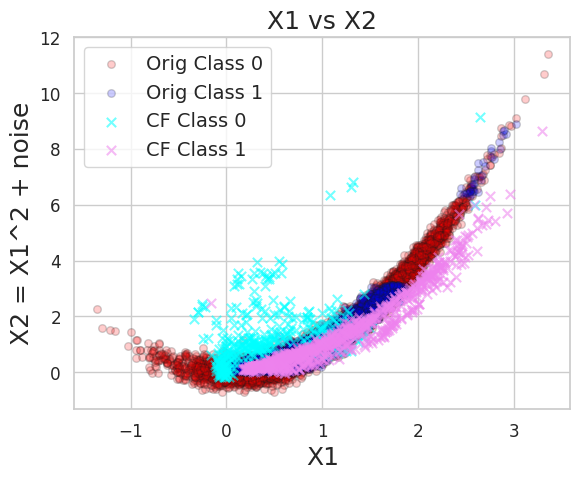

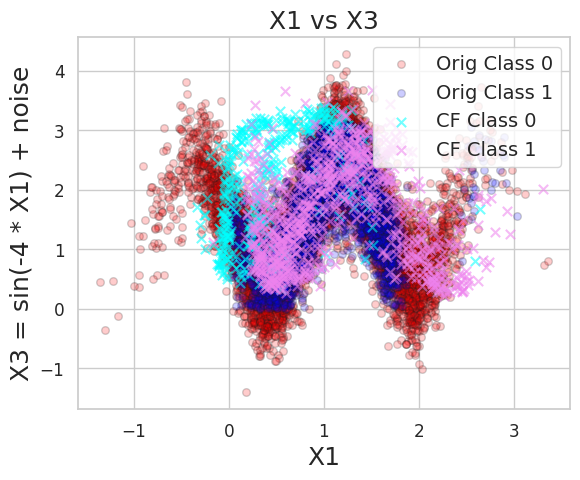

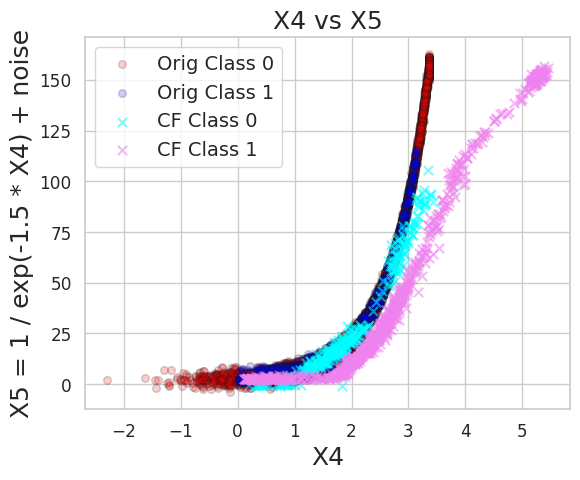

In [74]:
if __name__ == "__main__":
    main()